In [1]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams['axes.unicode_minus']=False

path = 'result/bayes_visualization'
if not os.path.exists(path):
    os.makedirs(path)
    

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))

In [2]:
def black_box(a, K, inputscaling, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    X_test = X[:,test_start : test_start + num_test]
    err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
    err = np.min(np.average(np.square(err), axis=1))
    return -np.log10(err)

def multistep_prediction(a, K, inputscaling, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])

    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x

    X_train = X[:,train_start : train_start + num_train]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    horizon = 100
    mse = []
    for h in range(horizon):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test]
            X_test = X[:,test_start : test_start + num_test]
        else:
            U_test = Y_pred[dim] 
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

        H = np.vstack((np.ones((1,num_test)),X_test))
        Y_pred = Wout @ H
        Y_true = Y[dim,test_start+h+1 : test_start + num_test + h+1]
        err = np.min(np.average(np.square(Wout @ H - Y_true), axis=1))
        mse.append(err)
    plt.figure()
    plt.plot(mse) 
    plt.yscale('log')
    plt.show()
    
def multistep_prediction_attn(a, K, inputscaling, beta, N_c = 100, reg=1e-6):

    W = W0/rhoW*K 
    Win = Win0*inputscaling
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in range(U.shape[1]):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
        X[:,t:t+1] = x
    X_train = X[:,train_start : train_start + num_train]  
    Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
    tau = svht(X_train, sv=Diag)
    N_v = np.sum(Diag>tau)
    MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]
    Cs = clustering((np.diag(Diag)@ Mr).T, N_c)  # N_c, N_v
    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    X_test = X[:,test_start : test_start + num_test]
    horizon = 100
    mse = []
    for h in range(horizon):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test]
            X_test = X[:,test_start : test_start + num_test]
        else:
            U_test = Y_pred[dim] 
            X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

        S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
        H = np.vstack((np.ones((1,num_test)), X_test, S))
        Y_pred = Wout @ H
        Y_true = Y[dim,test_start+h+1 : test_start + num_test + h+1]
        err = np.min(np.average(np.square(Wout @ H - Y_true), axis=1))
        mse.append(err)
    plt.figure()
    plt.plot(mse) 
    plt.yscale('log')
    plt.show()
    
def pairwise_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0
    return D

def clustering(data, N_c):
    estimator = KMeans(init='random', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

from functools import partial
def partial_black_box_attn(beta):
    reg=1e-6
    S = np.exp(- 2**beta * pairwise_distances(Cs, (np.diag(Diag)@ Mr).T))
    H = np.vstack((np.ones((1,num_train)), X_train, S))
    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

    S = np.exp( - 2**beta* pairwise_distances(Cs, (MlT @ X_test).T))
    H = np.vstack((np.ones((1,num_test)), X_test, S))
    err = np.min(np.average(np.square(Wout @ H - Y_test), axis=1))
    return -np.log10(err)

x
U shape: (1, 20000)
Y shape: (3, 20000)
|   iter    |  target   |     K     |     a     | inputs... |
-------------------------------------------------------------
|  1        |  5.868    |  0.7491   |  0.9507   |  1.464    |
|  2        |  6.226    |  1.197    |  0.156    |  0.312    |
|  3        |  5.653    |  0.1162   |  0.8662   |  1.202    |
|  4        |  4.918    |  1.416    |  0.02058  |  1.94     |
|  5        |  6.397    |  1.665    |  0.2123   |  0.3636   |
|  6        |  6.021    |  0.3668   |  0.3042   |  1.05     |
|  7        |  6.296    |  0.8639   |  0.2912   |  1.224    |
|  8        |  5.979    |  0.279    |  0.2921   |  0.7327   |
|  9        |  5.893    |  0.9121   |  0.7852   |  0.3993   |
|  10       |  5.837    |  1.028    |  0.5924   |  0.0929   |
|  11       |  6.017    |  1.215    |  0.1705   |  0.1301   |
|  12       |  5.991    |  1.898    |  0.9656   |  1.617    |
|  13       |  6.087    |  0.6092   |  0.09767  |  1.368    |
|  14       |  6.327    |  0

|  79       |  6.664    |  1.401    |  0.07798  |  0.9696   |
|  80       |  6.592    |  1.405    |  0.1172   |  0.8203   |
|  81       |  6.589    |  1.473    |  0.1556   |  0.8212   |
|  82       |  6.613    |  1.492    |  0.1014   |  0.7805   |
|  83       |  6.635    |  1.542    |  0.147    |  0.7515   |
|  84       |  6.658    |  1.372    |  0.0634   |  0.9786   |
|  85       |  6.653    |  1.552    |  0.1319   |  0.7976   |
|  86       |  6.64     |  1.56     |  0.1757   |  0.7908   |
|  87       |  6.665    |  1.597    |  0.1413   |  0.7727   |
|  88       |  6.675    |  1.373    |  0.07406  |  0.9636   |
|  89       |  6.598    |  1.585    |  0.1047   |  0.7613   |
|  90       |  6.657    |  1.616    |  0.1742   |  0.7648   |
|  91       |  6.683    |  1.612    |  0.1562   |  0.7996   |
|  92       |  6.69     |  1.63     |  0.1527   |  0.796    |
|  93       |  5.976    |  1.032    |  0.5025   |  0.1498   |
|  94       |  6.691    |  1.632    |  0.1522   |  0.7959   |
|  95   

|  159      |  6.718    |  1.914    |  0.1088   |  1.281    |
|  160      |  6.743    |  1.937    |  0.1473   |  1.291    |
|  161      |  6.677    |  1.965    |  0.09033  |  1.849    |
|  162      |  6.595    |  1.922    |  0.1916   |  1.841    |
|  163      |  6.765    |  1.89     |  0.1368   |  1.197    |
|  164      |  6.689    |  1.955    |  0.1589   |  1.546    |
|  165      |  2.376    |  1.983    |  0.01333  |  1.766    |
|  166      |  6.682    |  1.902    |  0.1094   |  1.893    |
|  167      |  6.654    |  1.965    |  0.197    |  1.633    |
|  168      |  6.626    |  1.975    |  0.1522   |  1.82     |
|  169      |  6.617    |  1.996    |  0.1543   |  1.918    |
|  170      |  6.739    |  1.994    |  0.1281   |  1.497    |
|  171      |  6.681    |  1.984    |  0.1215   |  1.883    |
|  172      |  6.55     |  2.0      |  0.2129   |  2.0      |
|  173      |  6.733    |  1.913    |  0.1222   |  1.193    |
|  174      |  6.686    |  1.962    |  0.09454  |  1.859    |
|  175  

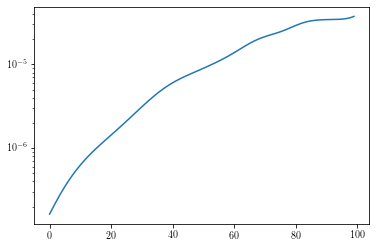

In [21]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

for inputdata, dim in zip(
    [
        'x',
#         'y',
#         'z', 
#         'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
#         [1],
#         [2],
#         [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)
    system_name = 'Lorenz'
    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = 3  
    resSize = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[dim,train_start + 1 : train_start + num_train + 1]
    Y_test = Y[dim,test_start + 1 : test_start + num_test + 1]

    seed = 42
    random.seed(seed) 
    np.random.seed(seed)
    Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
    W0 = np.random.rand(resSize,resSize)-0.5
    largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
    rhoW = np.sqrt(largest_eigvals[0])


    # Bounded region of parameter space
    pbounds = {
        'a': (0, 1), 
        'K': (0, 2),
        'inputscaling': (0,2),
    }
    
#     bounds_transformer = SequentialDomainReductionTransformer()


    optimizer = BayesianOptimization(
        f=black_box,
        pbounds=pbounds,
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=seed,
#         bounds_transformer=bounds_transformer
    )
    
#     optimizer.probe(
#         params=[0.1,1.9,1.0,1e-6],
#         lazy=True,
#     )

    
#     optimizer.maximize(
#         init_points=30,
#         n_iter=100,
#         acq="ucb", kappa=10, kappa_decay=0.95
#     )  
    optimizer.maximize(
        init_points=30,
        n_iter=200,
        acq="poi", xi=1e-4
    )
    
    print(optimizer.max)
    params = optimizer.max['params']
    a, K, inputscaling  = params['a'], params['K'], params['inputscaling']
    
    res = optimizer.res
    
    multistep_prediction(a, K, inputscaling)



In [23]:
x_obs = np.array([[r["params"]["a"], r["params"]["K"], r["params"]["inputscaling"]] for r in res])
y_obs = np.array([r["target"] for r in res])


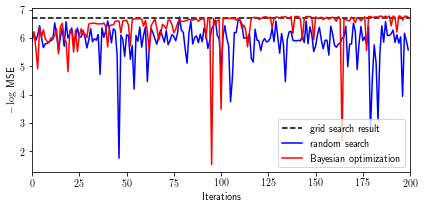

In [42]:
acc_min = [10**-np.max(y_obs[:i+1]) for i in range(len(y_obs))]
e = 1.910837838359768e-07
e = -np.log10(e)
plt.figure(figsize=(6,3))
plt.plot([0, 200], [e,e], 'k--', label='grid search result')
plt.plot(np.array(random_errs), 'b', label='random search')
plt.plot(y_obs, 'r', label='Bayesian optimization')

# plt.plot(acc_min, 'k--', label='BO cumulated minimum')

# plt.ylim([1e-7,1e-5])
plt.legend(loc='lower right')
plt.ylabel(r'$-\log$ MSE')
plt.xlabel('Iterations')
# plt.yscale('log')
plt.xlim([0,200])
plt.tight_layout()
plt.savefig(path + '/bo_vs_grid.pdf')

In [61]:
def plot(res):
    
    x_obs = np.array([[r["params"]["a"], r["params"]["K"], r["params"]["inputscaling"]] for r in res])
    y_obs = np.array([r["target"] for r in res])

    X = [[a, K, input_scaling] 
         for a in [0.1*i for i in range(1, 11)] 
         for K in [0.2*i for i in range(1,11)]         
         for input_scaling in [0.2*i for i in range(1,11)]]

    optimizer = BayesianOptimization(
        f=black_box,
        pbounds=pbounds,
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=seed,
    )
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(X, return_std=True)
    mu1 = mu
    mu1[mu1<5]=5
    mu1[mu1>7]=7

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=10, azim=-110)
    im = ax.scatter(*np.array(X).T, s=10, c=-mu1, cmap='jet')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\rho$')
    ax.set_zlabel(r'$s(W_{in})$')
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.75, 0.75, 1.5, 1]))
    plt.tight_layout()
    plt.show()


In [19]:
from tqdm.notebook import tqdm
for inputdata, dim in zip(
    [
        'x',
#         'y',
#         'z', 
#         'xyz'
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
#         [1],
#         [2],
#         [0,1,2]
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)
    system_name = 'Lorenz'
    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = 3  
    resSize = 100

    U_train = U[:,train_start : train_start + num_train]
    Y_train = Y[dim,train_start + 1 : train_start + num_train + 1]
    Y_test = Y[dim,test_start + 1 : test_start + num_test + 1]
    
    random_errs = []
    for seed in tqdm(range(200)):
        random.seed(seed) 
        np.random.seed(seed)
        Win0 = (np.random.rand(resSize,1+inSize)-0.5) * 2
        W0 = np.random.rand(resSize,resSize)-0.5
        largest_eigvals, _ = largest_eigsh(W0@W0.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])


        # Bounded region of parameter space
        pbounds = {
            'a': (0, 1), 
            'K': (0, 2),
            'inputscaling': (0,2),
        }
        a = np.random.rand()* (pbounds['a'][1] - pbounds['a'][0]) + pbounds['a'][0]
        K = np.random.rand()* (pbounds['K'][1] - pbounds['K'][0]) + pbounds['K'][0]
        inputscaling = np.random.rand()* (pbounds['inputscaling'][1] - pbounds['inputscaling'][0]) + pbounds['inputscaling'][0]

        err = black_box(a,K,inputscaling)
        random_errs.append(err)



x
U shape: (1, 20000)
Y shape: (3, 20000)


  0%|          | 0/200 [00:00<?, ?it/s]

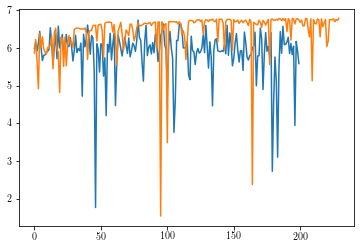

In [24]:
plt.plot(random_errs)
plt.plot(y_obs)